# Santander Customer Transaction Prediction

---

## Group:
Gleisson, Marcos, Lorena, Rodrigo, Max


## Dataset:
__[Kaggle Competition: Santander Customer Transaction Prediction](https://www.kaggle.com/c/santander-customer-transaction-prediction/)__

---

<img src = https://storage.googleapis.com/kaggle-media/competitions/santander/atm_image.png width=750>

---

## Hide / Show Code

In [6]:
from IPython.display import HTML
from IPython.display import Image

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to Show / Hide the code."></form>''')


## Prepare for data analysis
---

### Installing Models

In [ ]:
!pip install lightgbm
!pip install catboost


### Load packages

In [1]:
import pandas as pd
import numpy as np

from catboost import Pool, CatBoostClassifier
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc

# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.linear_model import LogisticRegression
# from sklearn import metrics
# from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns


### Load train dataset

In [2]:
#DataSet
df_train = pd.read_csv(r'data/train.csv.zip')


In [32]:
df_train.head()


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


## Data exploration
---

### Data info

In [4]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


### Looking for missing data

In [5]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)


,Total,Percent
var_199,0,0.0
var_61,0,0.0
var_71,0,0.0
var_70,0,0.0
var_69,0,0.0
var_68,0,0.0
var_67,0,0.0
var_66,0,0.0
var_65,0,0.0
var_64,0,0.0


### Numerical Variables

In [6]:
df_train.describe().round(2).T.head(20)


,count,mean,std,min,25%,50%,75%,max
target,200000.0,0.10,0.30,0.00,0.00,0.00,0.00,1.00
var_0,200000.0,10.68,3.04,0.41,8.45,10.52,12.76,20.32
var_1,200000.0,-1.63,4.05,-15.04,-4.74,-1.61,1.36,10.38
var_2,200000.0,10.72,2.64,2.12,8.72,10.58,12.52,19.35
var_3,200000.0,6.80,2.04,-0.04,5.25,6.82,8.32,13.19
var_4,200000.0,11.08,1.62,5.07,9.88,11.11,12.26,16.67
var_5,200000.0,-5.07,7.86,-32.56,-11.20,-4.83,0.92,17.25
var_6,200000.0,5.41,0.87,2.35,4.77,5.39,6.00,8.45
var_7,200000.0,16.55,3.42,5.35,13.94,16.46,19.10,27.69
var_8,200000.0,0.28,3.33,-10.51,-2.32,0.39,2.94,10.15


## Analysing target (y) feature

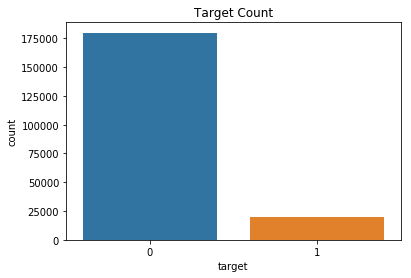

In [32]:
sns.countplot(df_train['target'])
plt.title('Target Count')
plt.show()


In [31]:
df_train['target'].value_counts(1)


0    0.89951
1    0.10049
Name: target, dtype: float64

### Features Density Plot

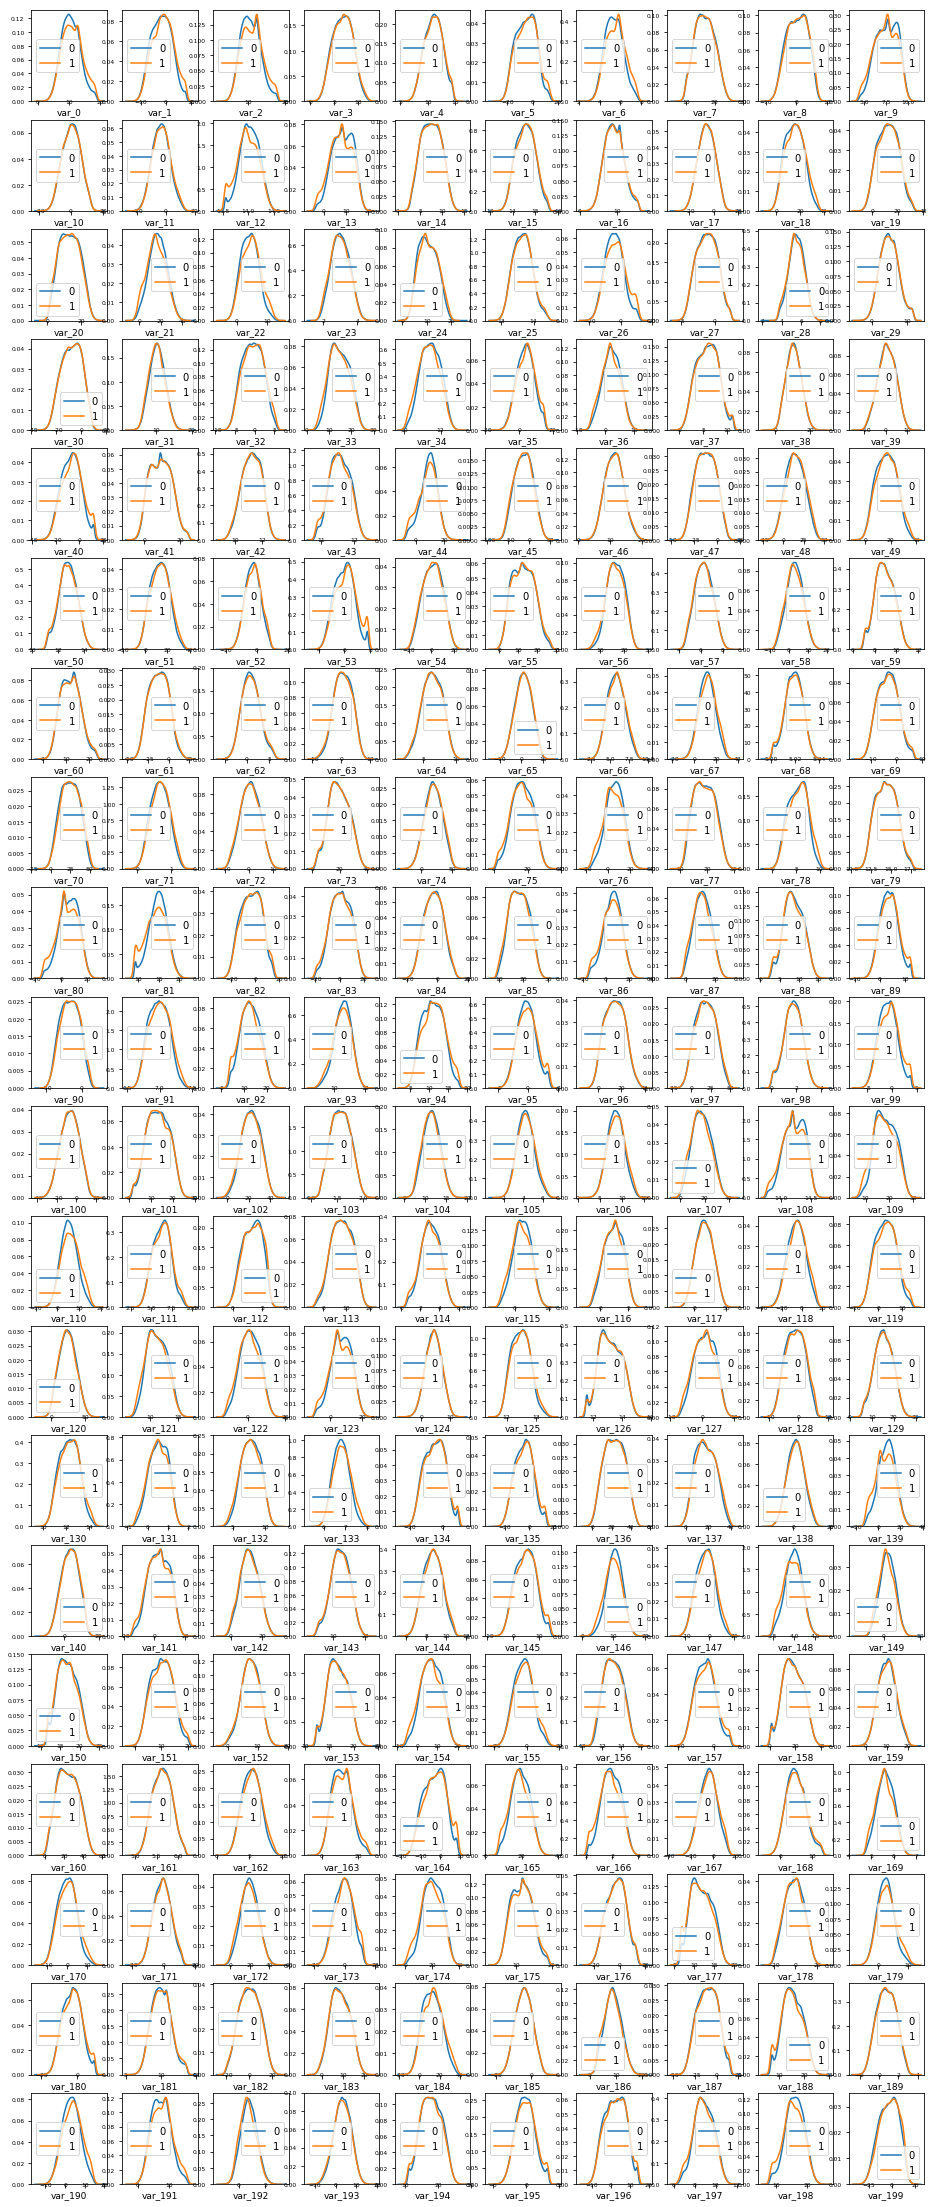

In [66]:
feat_list = list(df_train)[2:]
fig, ax = plt.subplots(16, 10, figsize=(16,40))
i = 0

for x in feat_list:
    i+=1
    plt.subplot(20, 10, i)
    sns.distplot(df_train[x][df_train['target']==0], hist=False, label='0')
    sns.distplot(df_train[x][df_train['target']==1], hist=False, label='1')
    plt.xlabel(x, fontsize=9)
    locs, labels = plt.xticks()
    plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
    plt.tick_params(axis='y', which='major', labelsize=6)
plt.show()


### Duplicated data

In [68]:
feat_list = list(df_train)[2:]
unique_train = []

for x in feat_list:
    values = df_train[x].value_counts()
    unique_train.append([x, values.max(), values.idxmax()])

pd.DataFrame(unique_train, columns=['Feature', 'Max duplicates', 'Value']).\
            sort_values(by = 'Max duplicates', ascending=False).head(10)


,Feature,Max duplicates,Value
68,var_68,1084,5.0214
108,var_108,313,14.1999
126,var_126,305,11.5356
12,var_12,203,13.5545
91,var_91,66,6.9785
103,var_103,61,1.6662
148,var_148,59,4.0456
71,var_71,54,0.7031
161,var_161,52,5.7688
25,var_25,41,13.6723


## Feature Engineering
---

### Creating new features with log

Creating new columns on the dataset with squared value to the top 15 features with significant different distribution for the two target values.
- var_0, var_1, var_2, var_5, var_9, var_12, var_13, var_26, var_76, var_81, var_108, var_110, var_139, var_148, var_191

In [75]:
feat_log = ['var_0',
'var_1',
'var_2',
'var_5',
'var_9',
'var_12',
'var_13',
'var_26',
'var_76',
'var_81',
'var_108',
'var_110',
'var_139',
'var_148',
'var_191']

for x in feat_log:
    df_train[x + '_sqrd'] = df_train[x] ** 2


### Standardizing Data

In [3]:
feat_list = list(df_train)[2:]
list_mean = []
list_std = []

for x in feat_list:
    list_mean.append(df_train[x].mean())
    list_std.append(df_train[x].std())

list_mean_std = pd.DataFrame({'feature':feat_list,
                              'mean': list_mean,
                              'std':list_std})
list_mean_std.head()

,feature,mean,std
0,var_0,10.679914,3.040051
1,var_1,-1.627622,4.050044
2,var_2,10.715192,2.640894
3,var_3,6.796529,2.043319
4,var_4,11.078333,1.623150


In [4]:
feat_list = list(df_train)[2:]

for i, x in enumerate(feat_list):
    df_train[x] = (df_train[x] - list_mean_std['mean'][i]) / list_mean_std['std'][i]


In [5]:
df_train.describe().round(2).T.head(10)


,count,mean,std,min,25%,50%,75%,max
target,200000.0,0.1,0.3,0.00,0.00,0.00,0.00,1.00
var_0,200000.0,-0.0,1.0,-3.38,-0.73,-0.05,0.68,3.17
var_1,200000.0,-0.0,1.0,-3.31,-0.77,0.00,0.74,2.96
var_2,200000.0,-0.0,1.0,-3.26,-0.75,-0.05,0.68,3.27
var_3,200000.0,-0.0,1.0,-3.35,-0.75,0.01,0.75,3.13
var_4,200000.0,-0.0,1.0,-3.70,-0.74,0.02,0.73,3.45
var_5,200000.0,-0.0,1.0,-3.50,-0.78,0.03,0.76,2.84
var_6,200000.0,0.0,1.0,-3.53,-0.74,-0.03,0.69,3.51
var_7,200000.0,-0.0,1.0,-3.28,-0.76,-0.03,0.75,3.26
var_8,200000.0,0.0,1.0,-3.24,-0.78,0.03,0.80,2.96


### Balacing DataSet

In [110]:
#Balacing DataSet
df_train_0 = df_train[df_train['target']==0]
df_train_1 = df_train[df_train['target']==1]

df_train_0 = df_train_0.sample(df_train_1.shape[0], replace=True)
df_train = pd.concat([df_train_0, df_train_1], ignore_index=True)

del df_train_0, df_train_1


In [111]:
#Target
df_train['target'].value_counts()


1    20098
0    20098
Name: target, dtype: int64

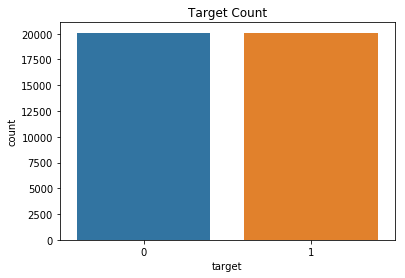

In [112]:
sns.countplot(df_train['target'])
plt.title('Target Count')
plt.show()


## Preparing Test Data

### Load test dataset

In [6]:
#DataSet
df_test = pd.read_csv(r'data/test.csv.zip')


In [37]:
df_test.head()


,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


### Data Exploration

In [11]:
#Data Info
df_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB


In [124]:
#Missing Data
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)


,Total,Percent
var_199,0,0.0
var_61,0,0.0
var_71,0,0.0
var_70,0,0.0
var_69,0,0.0
var_68,0,0.0
var_67,0,0.0
var_66,0,0.0
var_65,0,0.0
var_64,0,0.0


In [125]:
#Numerical Variables
df_test.describe().round(2).T.head(10)


,count,mean,std,min,25%,50%,75%,max
var_0,200000.0,10.66,3.04,0.19,8.44,10.51,12.74,22.32
var_1,200000.0,-1.62,4.04,-15.04,-4.70,-1.59,1.34,9.39
var_2,200000.0,10.71,2.63,2.36,8.74,10.56,12.50,18.71
var_3,200000.0,6.79,2.05,-0.02,5.23,6.82,8.33,13.14
var_4,200000.0,11.08,1.62,5.48,9.89,11.10,12.25,16.04
var_5,200000.0,-5.05,7.87,-27.77,-11.20,-4.83,0.94,17.25
var_6,200000.0,5.42,0.86,2.22,4.77,5.39,6.01,8.30
var_7,200000.0,16.53,3.42,5.71,13.93,16.42,19.09,28.29
var_8,200000.0,0.28,3.33,-9.96,-2.30,0.37,2.93,9.67
var_9,200000.0,7.57,1.23,4.24,6.62,7.63,8.58,11.00


In [126]:
#Duplicated Data
feat_list = list(df_test)[2:]
unique_test = []

for x in feat_list:
    values = df_test[x].value_counts()
    unique_test.append([x, values.max(), values.idxmax()])

pd.DataFrame(unique_train, columns=['Feature', 'Max duplicates', 'Value']).\
            sort_values(by = 'Max duplicates', ascending=False).head(10)


,Feature,Max duplicates,Value
68,var_68,1084,5.0214
108,var_108,313,14.1999
126,var_126,305,11.5356
12,var_12,203,13.5545
91,var_91,66,6.9785
103,var_103,61,1.6662
148,var_148,59,4.0456
71,var_71,54,0.7031
161,var_161,52,5.7688
25,var_25,41,13.6723


### Feature Engineering

In [78]:
#Creating new features with log

feat_log = ['var_0',
'var_1',
'var_2',
'var_5',
'var_9',
'var_12',
'var_13',
'var_26',
'var_76',
'var_81',
'var_108',
'var_110',
'var_139',
'var_148',
'var_191']

for x in feat_log:
    df_test[x + '_sqrd'] = df_test[x] ** 2

In [7]:
#Standardizing Data with Mean and STD from TrainData
feat_list = list(df_test)[1:]

for i, x in enumerate(feat_list):
    df_test[x] = (df_test[x] - list_mean_std['mean'][i]) / list_mean_std['std'][i]


In [8]:
#Numerical Variables
df_test.describe().round(2).T.head(10)


,count,mean,std,min,25%,50%,75%,max
var_0,200000.0,-0.01,1.0,-3.45,-0.74,-0.05,0.68,3.83
var_1,200000.0,0.00,1.0,-3.31,-0.76,0.01,0.73,2.72
var_2,200000.0,-0.00,1.0,-3.17,-0.75,-0.06,0.67,3.03
var_3,200000.0,-0.00,1.0,-3.34,-0.77,0.01,0.75,3.11
var_4,200000.0,-0.00,1.0,-3.45,-0.73,0.01,0.72,3.06
var_5,200000.0,0.00,1.0,-2.89,-0.78,0.03,0.76,2.84
var_6,200000.0,0.01,1.0,-3.68,-0.73,-0.02,0.69,3.34
var_7,200000.0,-0.00,1.0,-3.17,-0.76,-0.04,0.75,3.44
var_8,200000.0,-0.00,1.0,-3.07,-0.78,0.03,0.79,2.81
var_9,200000.0,0.00,1.0,-2.69,-0.76,0.05,0.82,2.78


## Sppliting Data
---

In [9]:
X = df_train.drop(['target','ID_code'], axis=1)
y = df_train['target']
X_test = df_test.drop(['ID_code'], axis=1)


## Models
---

### Catboost

In [10]:
model_cat = CatBoostClassifier(loss_function="Logloss", eval_metric="AUC")

kf = KFold(n_splits=5, random_state=42, shuffle=True)

y_valid_pred = 0 * y
y_test_pred = 0

for idx, (train_index, valid_index) in enumerate(kf.split(df_train)):
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    X_train, X_valid = X.iloc[train_index,:], X.iloc[valid_index,:]
    _train = Pool(X_train, label=y_train)
    _valid = Pool(X_valid, label=y_valid)
    print( "\nFold ", idx)
    fit_model = model_cat.fit(_train,
                          eval_set=_valid,
                          use_best_model=True,
                          verbose=200
                         )
    pred = fit_model.predict_proba(X_valid)[:,1]
    print( "  auc = ", roc_auc_score(y_valid, pred) )
    y_valid_pred.iloc[valid_index] = pred
    y_test_pred += fit_model.predict_proba(X_test)[:,1]
y_test_pred /= 5



Fold  0
Learning rate set to 0.132949
0:	test: 0.5315318	best: 0.5315318 (0)	total: 286ms	remaining: 4m 45s
200:	test: 0.8822301	best: 0.8822301 (200)	total: 33.5s	remaining: 2m 13s
400:	test: 0.8919677	best: 0.8919677 (400)	total: 1m 8s	remaining: 1m 41s
600:	test: 0.8940936	best: 0.8941278 (598)	total: 1m 43s	remaining: 1m 8s
800:	test: 0.8952451	best: 0.8953126 (746)	total: 2m 18s	remaining: 34.5s
999:	test: 0.8953725	best: 0.8954355 (991)	total: 2m 54s	remaining: 0us

bestTest = 0.8954355364
bestIteration = 991

Shrink model to first 992 iterations.
  auc =  0.895435536443349

Fold  1
Learning rate set to 0.132949
0:	test: 0.5274412	best: 0.5274412 (0)	total: 216ms	remaining: 3m 35s
200:	test: 0.8836087	best: 0.8836087 (200)	total: 36.3s	remaining: 2m 24s
400:	test: 0.8941821	best: 0.8942215 (399)	total: 1m 13s	remaining: 1m 49s
600:	test: 0.8971854	best: 0.8971897 (599)	total: 1m 51s	remaining: 1m 13s
800:	test: 0.8975168	best: 0.8977881 (710)	total: 2m 26s	remaining: 36.5s
999:	

In [11]:
param = {
        'num_leaves': 10,
        'max_bin': 119,
        'min_data_in_leaf': 11,
        'learning_rate': 0.02,
        'min_sum_hessian_in_leaf': 0.00245,
        'bagging_fraction': 1.0, 
        'bagging_freq': 5, 
        'feature_fraction': 0.05,
        'lambda_l1': 4.972,
        'lambda_l2': 2.276,
        'min_gain_to_split': 0.65,
        'max_depth': 14,
        'save_binary': True,
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,
    }

In [12]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
oof = np.zeros(len(X))
predictions = np.zeros(len(X_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(skf.split(X.values, y.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[val_idx], label=y.iloc[val_idx])

    num_round = 10000
    model_lgb = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
    oof[val_idx] = model_lgb.predict(X.iloc[val_idx], num_iteration=model_lgb.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = list(X)
    fold_importance_df["importance"] = model_lgb.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration) / 5

print("CV score: {:<8.5f}".format(roc_auc_score(y, oof)))


fold n°0
Training until validation scores don't improve for 100 rounds.
[1000]	training's auc: 0.904417	valid_1's auc: 0.885674
[2000]	training's auc: 0.920217	valid_1's auc: 0.89429
[3000]	training's auc: 0.930407	valid_1's auc: 0.897863
[4000]	training's auc: 0.937953	valid_1's auc: 0.899162
Early stopping, best iteration is:
[4841]	training's auc: 0.943539	valid_1's auc: 0.899581
fold n°1
Training until validation scores don't improve for 100 rounds.
[1000]	training's auc: 0.904401	valid_1's auc: 0.88164
[2000]	training's auc: 0.920415	valid_1's auc: 0.89061
[3000]	training's auc: 0.930394	valid_1's auc: 0.895022
[4000]	training's auc: 0.937922	valid_1's auc: 0.897006
Early stopping, best iteration is:
[4770]	training's auc: 0.943065	valid_1's auc: 0.897508
fold n°2
Training until validation scores don't improve for 100 rounds.
[1000]	training's auc: 0.904001	valid_1's auc: 0.886355
[2000]	training's auc: 0.919976	valid_1's auc: 0.89469
[3000]	training's auc: 0.930269	valid_1's auc:

## Including Predictions on DataFrame

In [29]:
#Predict from catboost
df_test['catboost'] = y_test_pred


In [30]:
#Predict from LGB
df_test['lgb'] = predictions


In [31]:
#Creating a target columns use a avarege from models
df_test['target'] = (df_test['target1'] * 2 + df_test['target2']) / 3



In [69]:
#Ajdusting Submission Data Set
df_test = df_test[['ID_code', 'target']]


In [73]:
#Creating Submission CSV
df_test.to_csv('data/submission.csv', index=False)


Agora é só subir o arquivo criado no kaggle!! Eu subi e tive o resultado de 0.899